In [1]:
import pandas as pd
import matplotlib.pyplot as plt


Bad key text.latex.unicode in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True

# Evaluation

Article Source: A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data 
Goldstein M, Uchida S (2016) A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data. PLOS ONE 11(4): e0152173. https://doi.org/10.1371/journal.pone.0152173

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

I'm going to test the following dataset:
1. Pen-Global
1. Pen-Local
1. Speech
1. Aloi

On the following metrics: ROC-AUC

## Pen-Global Dataset

Paper version: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/OPQMVF/KQYDN9&version=1.0

Original UCI: https://archive.ics.uci.edu/ml/datasets/Pen-Based%20Recognition%20of%20Handwritten%20Digits

In [2]:
input_names = []

for i in range(8):
    input_names.append(f'x{i}')
    input_names.append(f'y{i}')

data = pd.read_csv('/Users/maxfrax/Downloads/pen-global-unsupervised-ad.csv', names=input_names+['outlier'])
data

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,outlier
0,47.0,100.0,27.0,81.0,57.0,37.0,26.0,0.0,0.0,23.0,56.0,53.0,100.0,90.0,40.0,98.0,n
1,0.0,89.0,27.0,100.0,42.0,75.0,29.0,45.0,15.0,15.0,37.0,0.0,69.0,2.0,100.0,6.0,o
2,0.0,57.0,31.0,68.0,72.0,90.0,100.0,100.0,76.0,75.0,50.0,51.0,28.0,25.0,16.0,0.0,o
3,0.0,100.0,7.0,92.0,5.0,68.0,19.0,45.0,86.0,34.0,100.0,45.0,74.0,23.0,67.0,0.0,o
4,0.0,67.0,49.0,83.0,100.0,100.0,81.0,80.0,60.0,60.0,40.0,40.0,33.0,20.0,47.0,0.0,o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,57.0,89.0,0.0,100.0,1.0,68.0,43.0,34.0,30.0,0.0,1.0,31.0,41.0,65.0,100.0,86.0,n
805,20.0,77.0,61.0,100.0,100.0,80.0,48.0,46.0,9.0,7.0,68.0,0.0,25.0,39.0,0.0,82.0,n
806,84.0,90.0,0.0,91.0,51.0,56.0,98.0,19.0,36.0,0.0,43.0,40.0,100.0,75.0,62.0,100.0,n
807,42.0,99.0,55.0,61.0,71.0,24.0,18.0,0.0,0.0,30.0,64.0,61.0,100.0,94.0,9.0,100.0,n


Let's plot the first number to show we understood the dataset correctly. As we can see the plot shows the number 8, which is expected since the normal class is just the number 8.

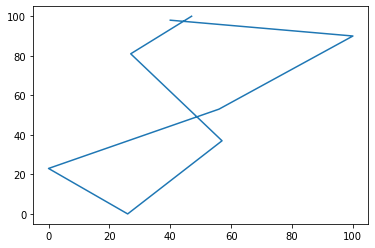

0    n
Name: outlier, dtype: object

In [3]:
x = []
y = []

for i, v in enumerate(data[input_names][0:1].values[0]):
    if i % 2 == 0:
        x.append(v)
    else:
        y.append(v)
        
plt.plot(x, y)
plt.show()

data[0:1]['outlier']

### Replicating: One Class SVM

I'm going to use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html since both the paper and sklearn refer to:

Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.

In the paper they train using only the normal data, and test with both normal data and outliers.
The hyper parameters tested are 0.2 < v < 0.8 and automatic tuning for the Gaussian kernel.

### My Algorithm: BSVClassifier

### Federated Learning: BSVClassifier